# 01. PyTorch Workflow

Exploring an example PyTorch end-to-end workflow.

Course video - [Source](https://www.youtube.com/watch?v=Z_ikDlimN6A)

GitHub Repo - [Source](https://github.com/Yer-Marti/PyTorch-Course)

PyTorch Doc - [Source](https://pytorch.org/docs/stable/index.html)

## Contents

* [Introduction](#scrollTo=W6XUlSsRWXLf&line=1&uniqifier=1)
* [Data (preparing and loading)](#scrollTo=_30UCxeUtOd-&line=21&uniqifier=1)
* [Building a model](#scrollTo=q3NXI_nt2Tx1&line=1&uniqifier=1)
* [Training a model](#scrollTo=jPL0cf7xD7P2&line=7&uniqifier=1)
* [Testing a model](#scrollTo=c4STfabazP9d&line=3&uniqifier=1)
* [Saving and loading a model in PyTorch](#scrollTo=Lk16upd56ZvQ&line=1&uniqifier=1)
* [Putting it all together](#scrollTo=xyxzBGiTrO-f&line=1&uniqifier=1)
* [Exercises](#scrollTo=zn9YHlp6uDSM&line=3&uniqifier=1)

## Introduction

What we are covering:

1. Data (prepare and load)
2. Build model
3. Fitting the model into the data (training)
4. Making predictions and evaluating a model (inference)
5. Saving and loading a model
6. Putting it all together

In [1]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt
import numpy as np

## 1. Data (preparing and loading)

Data can be almost anything in machine learning

* Excel sheet
* Images
* Videos
* Audio
* Text
* [...]

Machine learning is a game of two parts:

1. Convert data into a numerical representation.
2. Build a model to learn patterns in that numerical representation.

To showcase this, let's create some *known* data using the linear regression formula.

Linear regression formula: `y = a + bx`

> **Note:** in ML `b` is often refered as **weight** and `a` as **bias**.

In [2]:
# Create known parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [3]:
len(X), len(y)

(50, 50)

We know what the relationship between `X` and `y` is, so now we need to get the model to come up with the formula by itself.

Tensor `X` represents the `input`, and `y` represents the `output`.

### Splitting data into training and testing sets

Let's create a training and testing set with our data.

In [4]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

### Visualize the data

Using `matplotlib` to visualize the data.

In [5]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  # Plot the predictions if there are
  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14})

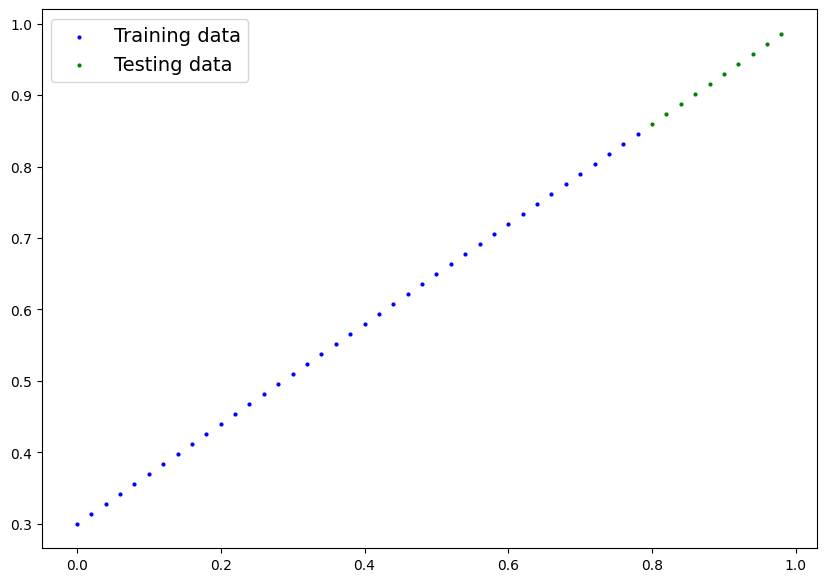

In [6]:
plot_predictions();

## 2. Building a model

What our model does:

* Start with random values (weight and bias)
* Look at training data and adjust those random values to better represent (or get closer to) the ideal values (the weight and bias we used to create our data)

How does it do so?

Through two main algorithms:
1. Gradient descent
2. Backpropagation

In [7]:
# Create linear regression model class
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float)) # default (=float32)
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))

  # Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data
    return self.weights * x + self.bias # this is the linear regression formula

### PyTorch model building essentials

* `torch.nn` - contains all of the buildings for computational graphs (a neural network can be considered a computational graph)
* `torch.nn.Parameter` - what parameters should our model try and learn, often a PyTorch layer from `torch.nn` will set these for us
* `torch.nn.Module` - the base class for all neural network modules, if you subclass it, you must override `forward()` method
* `torch.optim` - this is where the optimizers in PyTorch live, they will help with gradient descent
* `def forward()` - all `nn.Module` subclasses require to override this method, it defines what happens in the forward computation

### Checking the contents of our PyTorch model

Now that we have created a model, we can see what's inside.

We can check our model parameters or what's inside our model using `.parameters()`.

In [8]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model
model_0 = LinearRegressionModel()

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [9]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions

To check our model's predictive power, we use `torch.inference_mode()`. We can see how well it predicts `y_test` based on `X_test`.

When we pass data through our model, it's going to run it through the `forward()` method.

In [10]:
# Make predictions with model
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

Leaving the model at random:

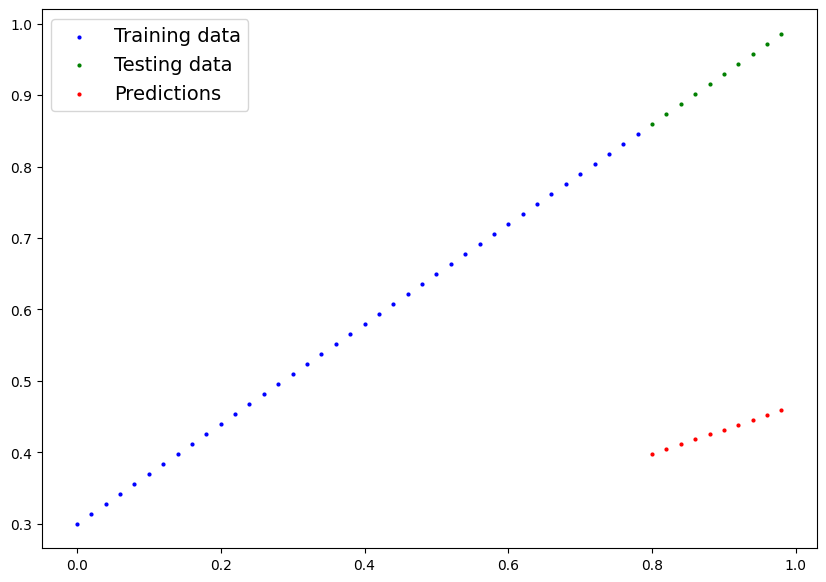

In [11]:
plot_predictions(predictions=y_preds)

## 3. Training a model

The whole idea of training is for a model to move from some *unknown* parameters (random initial values) to somo *known* parameters. A.k.a improve the representation of the data.

One way to measure how poor or how wrong your model's predictions are is to use a loss function.

> **Note:** Loss function may also be called cost function or criterion in different areas. For our case, we're going to refer to it as loss function.

Terms:
* **Loss function:** A function to measure how wrong your model's predictions are to the ideal predictions. The lower, the better.
* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters (e.g. weight and bias) to improve the loss function.

Specifically with PyTorch we need:
* A training loop
* A testing loop

In [12]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [13]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Loss functions and optimizers

L1 loss function (a.k.a Main Absolute Error) is used for number predictions.

SGD (Stochastic Gradient Descent) is an optimizer that uses random numbers to minimize the loss function. For example, if the weight is increased via a random number that is greater than the actual and it lowers the loss function, the optimizer will notice that and continue to increase the weight's value.

Definitions:
* `params` - Parameters defined by the model.
* `lr` - Learning rate. It measures the change in the parameters. The greater the value, the greater the change in the model's parameters. This is an hyperparameter.
* Hyperparameter - These are the parameters defined by the programmer and not the model itself (the latter are called **parameters**).

In [14]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

Which loss function and optimizer should I use?

This is problem specific and comes with experience. For a regression problem (this example), a loss function of `nn.L1Loss()` and an optimizer like `torch.optim.SGD()` will be enough. But for a classification problem like distinguishing a dog from a cat, you will likely want to use a `nn.BCELoss()` (Binary Cross Entropy Loss).

### Building a training loop and a testing loop

Things we need in a training loop:
0. Loop though the data
1. Forward pass (this involve data moving though our model's `forward()`) - also called forward propagation
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backward though the network to calculate the gradients of each of the parameters of our model with respect to the loss function (**backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)

In [15]:
model_0.state_dict() # State previous to training loop

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

For the time being, we are coding the training and testing loop together. Later, we will be externalising them.

In [16]:
torch.manual_seed(42)

# An epoch is one loop though the data... (this is a hyperparameters cuz we've set it ourselves)
epochs = 200

# Track values of the model
epoch_count = []
loss_values = []
test_loss_values = []

# 0. Loop though the data
for epoch in range(epochs):

  # Set the model to training mode
  model_0.train() # train mode in PyTorch sets all parameters that require gradients to require gradients

  # 1. Forward pass using forward() method
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation
  loss.backward()

  # 5. Step the optimizer
  optimizer.step() # by default, how the optimizer changes will accumulate through the loop, so we have to zero them above in step 3 for the next iteration of the loop

  # Testing
  model_0.eval() # turns off gradient tracking and other settings not needed for evaluation/testing (such as dropout/batch norm layers)
  with torch.inference_mode(): # better than torch.no_grad()
    # 1. Forward pass
    test_pred = model_0(X_test)

    # 2. Calculate test loss
    test_loss = loss_fn(test_pred, y_test)

  # Print out what is happening
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)

    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
    print(f"State dict: {model_0.state_dict()}\n")

Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
State dict: OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])

Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
State dict: OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])

Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
State dict: OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])

Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
State dict: OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])

Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
State dict: OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])

Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
State dict: OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])

Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.0888663

## 4. Testing a model

> **Note:** testing loop is above because we coded it inside the same loop as the training phase.

Visualize predictions after 200 epochs:

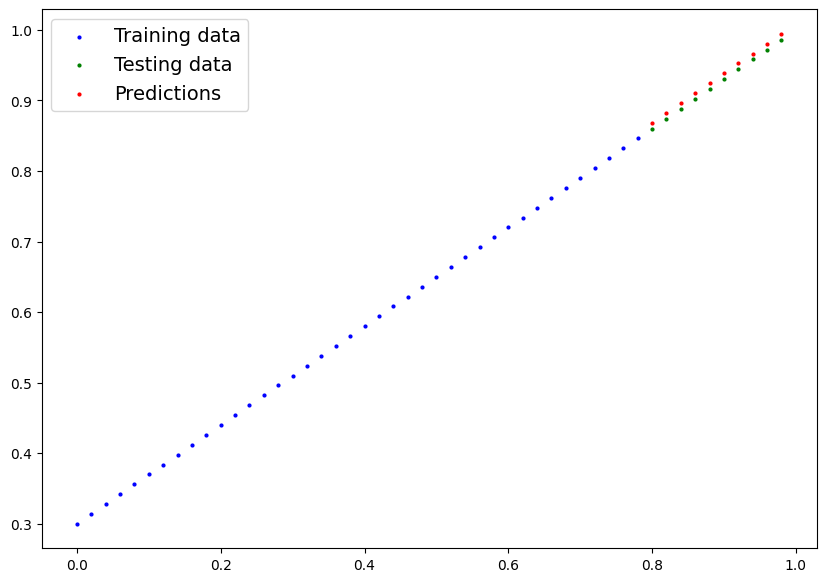

In [17]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

plot_predictions(predictions=y_preds_new)

We can plot the loss curves with the variables defined previously (`epoch_count`, `loss_values` and `test_loss_values`)

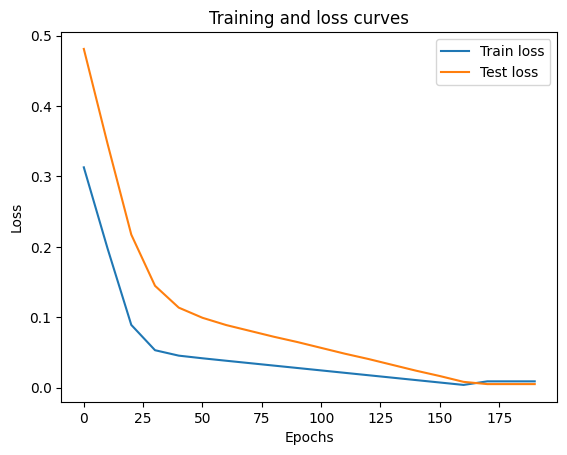

In [18]:
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

## 5. Saving and loading a model in PyTorch

There are three main methods for saving and loading models in PyTorch.

1. `torch.save()` - allows you to save a PyTorch object in Python's pickle format
2. `torch.load()` - allows you to load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - allows to load a model's saved state dictionary (recommended)

### Saving

In [19]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME # pathlib syntax

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [20]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1680 Mar  8 09:47 01_pytorch_workflow_model_0.pth


### Loading

Since we saved the `state_dict()` of our model rather than the entire model, we'll create a new instance of our model class and load the saved `state_dict()` into that.

In [21]:
# Loading a PyTorch model

# 1. Create a new instance of our model
loaded_model_0 = LinearRegressionModel()

# 2. Load the saved state_dict of model_0 (this will update the new instance with the loaded parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

We can check if the `state_dict()` for both models is the same:

In [22]:
print(f"Model: {model_0.state_dict()}\n\nLoaded model: {loaded_model_0.state_dict()}")

Model: OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

Loaded model: OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])


## 6. Putting it all together

This is how all the steps together should look like.

In [23]:
# Imports
import torch
import numpy as np
import matplotlib as mpl
from torch import nn

# Check version
torch.__version__

'2.1.0+cu121'

Create device-agnostic code.

This means that if we've got access to a GPU, our code will use it for potentially faster computing. If no GPU is available, the code will default to using a CPU.

In [24]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


### Data

In [25]:
# Create some data using linear regression
weight = 0.7
bias = 0.3

# Create range of values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [26]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

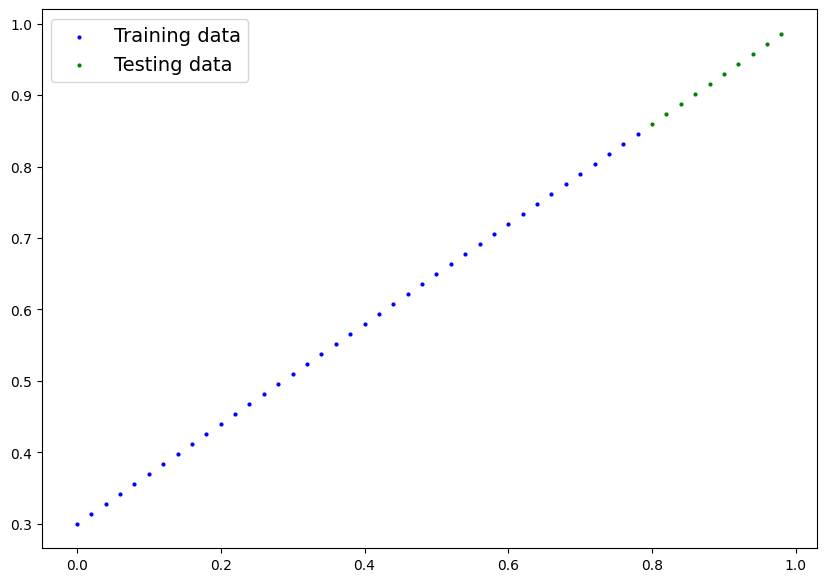

In [27]:
# Plot the data
plot_predictions(X_train, y_train, X_test, y_test)

### Building the model

In [28]:
# Create a linear model by subclassing nn.Module
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # Use nn.Linear() to create the parameters (also called: linear transform, probing layer, fully connected layer, dense layer)
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1) # 1 parameter input --> 1 parameter output

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

# Set seed
torch.manual_seed(42)

model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [29]:
# Check the model current device
next(model_1.parameters()).device

device(type='cpu')

In [30]:
# Set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

### Training and testing the model

In [31]:
# Setup loss function
loss_fn = nn.L1Loss()

# Setup optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [32]:
# Training loop
torch.manual_seed(42)

epochs = 200

# Put data on target device (device agnostic code for the data)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  # 1. Forward
  y_pred = model_1(X_train)

  # 2. Calculate loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Backpropagation
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)

    test_loss = loss_fn(test_pred, y_test)

  # Printing
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | State: {model_1.state_dict()} | Loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | State: OrderedDict([('linear_layer.weight', tensor([[0.7606]], device='cuda:0')), ('linear_layer.bias', tensor([0.8200], device='cuda:0'))]) | Loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 10 | State: OrderedDict([('linear_layer.weight', tensor([[0.7216]], device='cuda:0')), ('linear_layer.bias', tensor([0.7200], device='cuda:0'))]) | Loss: 0.439968079328537 | Test loss: 0.4392664134502411
Epoch: 20 | State: OrderedDict([('linear_layer.weight', tensor([[0.6826]], device='cuda:0')), ('linear_layer.bias', tensor([0.6200], device='cuda:0'))]) | Loss: 0.3247582018375397 | Test loss: 0.30455657839775085
Epoch: 30 | State: OrderedDict([('linear_layer.weight', tensor([[0.6436]], device='cuda:0')), ('linear_layer.bias', tensor([0.5200], device='cuda:0'))]) | Loss: 0.20954833924770355 | Test loss: 0.16984669864177704
Epoch: 40 | State: OrderedDict([('linear_layer.weight', tensor([[0.6046]], device='cuda:0')), ('linear_layer.bias', tensor([0.4200], device='cuda:0'))]

### Making evaluation on predictions

In [33]:
# Turn model into eval mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
  y_preds = model_1(X_test)

y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

> **Note:** `matplotlib` uses `numpy` so the data need to be passed to the CPU first.

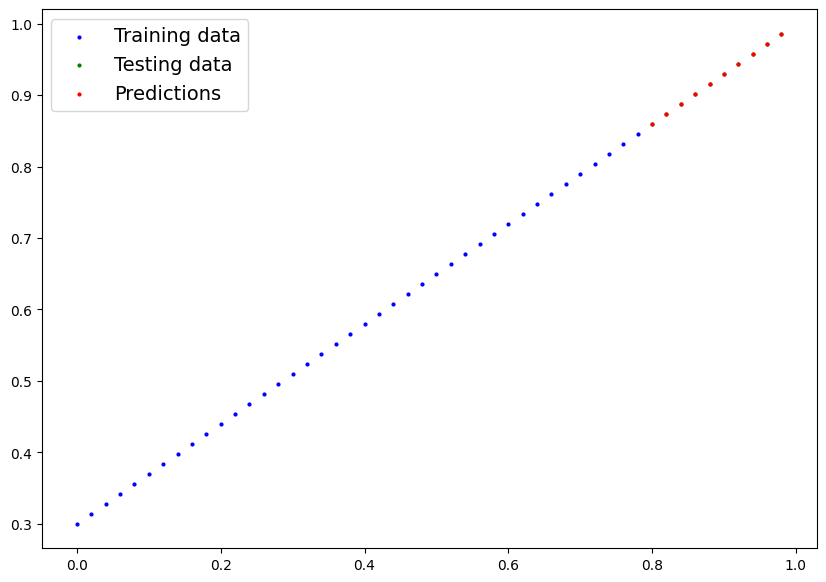

In [34]:
# Check out the plot
plot_predictions(predictions=y_preds.cpu())

### Saving and loading the model

In [35]:
# Create save path
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

MODEL_SAVE_PATH

PosixPath('models/01_pytorch_workflow_model_1.pth')

In [36]:
# Save the model
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)

In [37]:
# Load the model
loaded_model_1 = LinearRegressionModelV2()
loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Put loaded model in device
loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [38]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [39]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

## Exercises

[Source](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/01_pytorch_workflow.ipynb)

In [40]:
import torch
from torch import nn
import matplotlib.pyplot as plt

In [41]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

1. Create a straight line dataset using the linear regression formula (`weight * X + bias`).

* Set `weight=0.3` and `bias=0.9` there should be at least 100 datapoints total.
* Split the data into 80% training, 20% testing.
* Plot the training and testing data so it becomes visual

In [42]:
# Create the data parameters
weight = 0.3
bias = 0.9
# Make X and y using linear regression feature
X = torch.arange(0,1,0.01).unsqueeze(dim = 1)
y = weight * X + bias
print(f"Number of X samples: {len(X)}")
print(f"Number of y samples: {len(y)}")
print(f"First 10 X & y samples:\nX: {X[:10]}\ny: {y[:10]}")

Number of X samples: 100
Number of y samples: 100
First 10 X & y samples:
X: tensor([[0.0000],
        [0.0100],
        [0.0200],
        [0.0300],
        [0.0400],
        [0.0500],
        [0.0600],
        [0.0700],
        [0.0800],
        [0.0900]])
y: tensor([[0.9000],
        [0.9030],
        [0.9060],
        [0.9090],
        [0.9120],
        [0.9150],
        [0.9180],
        [0.9210],
        [0.9240],
        [0.9270]])


In [43]:
# Split the data into training and testing
train_split = int(len(X) * 0.8)
X_train = X[:train_split]
y_train = y[:train_split]
X_test = X[train_split:]
y_test = y[train_split:]
len(X_train),len(y_train),len(X_test),len(y_test)

(80, 80, 20, 20)

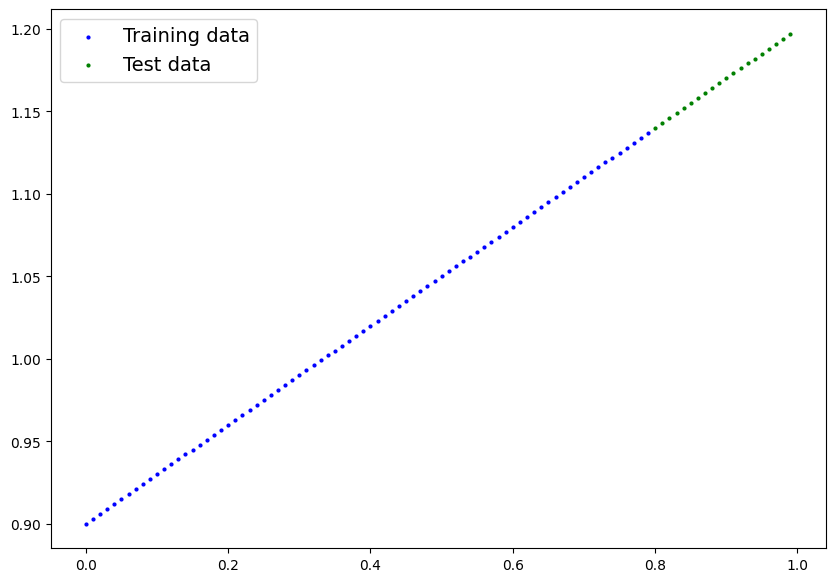

In [44]:
# Plot the training and testing data
def plot_predictions(train_data = X_train,
                 train_labels = y_train,
                 test_data = X_test,
                 test_labels = y_test,
                 predictions = None):
  plt.figure(figsize = (10,7))
  plt.scatter(train_data,train_labels,c = 'b',s = 4,label = "Training data")
  plt.scatter(test_data,test_labels,c = 'g',s = 4,label = "Test data")

  if predictions is not None:
    plt.scatter(test_data,predictions,c = 'r',s = 4,label = "Predictions")
  plt.legend(prop = {"size" : 14})
plot_predictions()

2. Build a PyTorch model by subclassing `nn.Module`.


* Inside should be a randomly initialized `nn.Parameter()` with `requires_grad=True`, one for `weights` and one for `bias`.
* Implement the `forward()` method to compute the linear regression function you used to create the dataset in 1.
* Once you've constructed the model, make an instance of it and check its `state_dict()`.

  > **Note:** If you'd like to use `nn.Linear()` instead of `nn.Parameter()` you can.

In [45]:
# Create PyTorch linear regression model by subclassing nn.Module
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weight = nn.Parameter(data=torch.randn(1,
                                              requires_grad=True,
                                              dtype=torch.float
                                              ))

    self.bias = nn.Parameter(data=torch.randn(1,
                                              requires_grad=True,
                                              dtype=torch.float
                                              ))

  def forward(self, x):
    return self.weight * x + self.bias

torch.manual_seed(42)
model_1 = LinearRegressionModel()
model_1,model_1.state_dict()

(LinearRegressionModel(),
 OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))]))

In [46]:
next(model_1.parameters()).device

device(type='cpu')

In [47]:
# Instantiate the model and put it to the target device
model_1.to(device)
list(model_1.parameters())

[Parameter containing:
 tensor([0.3367], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.1288], device='cuda:0', requires_grad=True)]

3. Create a loss function and optimizer using `nn.L1Loss()` and `torch.optim.SGD(params, lr)` respectively.


* Set the learning rate of the optimizer to be 0.01 and the parameters to optimize should be the model parameters from the model you created in 2.
* Write a training loop to perform the appropriate training steps for 300 epochs.
* The training loop should test the model on the test dataset every 20 epochs.


In [48]:
# Create the loss function and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params = model_1.parameters(),
                            lr = 0.01)

In [49]:
# Training loop
# Train model for 300 epochs
torch.manual_seed(42)

epochs = 300

# Send data to target device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  ### Training

  # Put model in train mode
  model_1.train()

  # 1. Forward pass
  y_pred = model_1(X_train)

  # 2. Calculate loss
  loss = loss_fn(y_pred,y_train)

  # 3. Zero gradients
  optimizer.zero_grad()

  # 4. Backpropagation
  loss.backward()

  # 5. Step the optimizer
  optimizer.step()

  ### Perform testing every 20 epochs
  if epoch % 20 == 0:
    # Put model in evaluation mode and setup inference context
    model_1.eval()
    with torch.inference_mode():
      # 1. Forward pass
      y_preds = model_1(X_test)
      # 2. Calculate test loss
      test_loss = loss_fn(y_preds,y_test)
      # Print out what's happening
      print(f"Epoch: {epoch} | Train loss: {loss:.3f} | Test loss: {test_loss:.3f}")

Epoch: 0 | Train loss: 0.757 | Test loss: 0.725
Epoch: 20 | Train loss: 0.525 | Test loss: 0.454
Epoch: 40 | Train loss: 0.294 | Test loss: 0.183
Epoch: 60 | Train loss: 0.077 | Test loss: 0.073
Epoch: 80 | Train loss: 0.053 | Test loss: 0.116
Epoch: 100 | Train loss: 0.046 | Test loss: 0.105
Epoch: 120 | Train loss: 0.039 | Test loss: 0.089
Epoch: 140 | Train loss: 0.032 | Test loss: 0.074
Epoch: 160 | Train loss: 0.025 | Test loss: 0.058
Epoch: 180 | Train loss: 0.018 | Test loss: 0.042
Epoch: 200 | Train loss: 0.011 | Test loss: 0.026
Epoch: 220 | Train loss: 0.004 | Test loss: 0.009
Epoch: 240 | Train loss: 0.004 | Test loss: 0.006
Epoch: 260 | Train loss: 0.004 | Test loss: 0.006
Epoch: 280 | Train loss: 0.004 | Test loss: 0.006


4. Make predictions with the trained model on the test data.

* Visualize these predictions against the original training and testing data (**note:** you may need to make sure the predictions are not on the GPU if you want to use non-CUDA-enabled libraries such as matplotlib to plot).

In [50]:
# Make predictions with the model
model_1.eval()

with torch.inference_mode():
  y_preds = model_1(X_test)
y_preds

tensor([[1.1464],
        [1.1495],
        [1.1525],
        [1.1556],
        [1.1587],
        [1.1617],
        [1.1648],
        [1.1679],
        [1.1709],
        [1.1740],
        [1.1771],
        [1.1801],
        [1.1832],
        [1.1863],
        [1.1893],
        [1.1924],
        [1.1955],
        [1.1985],
        [1.2016],
        [1.2047]], device='cuda:0')

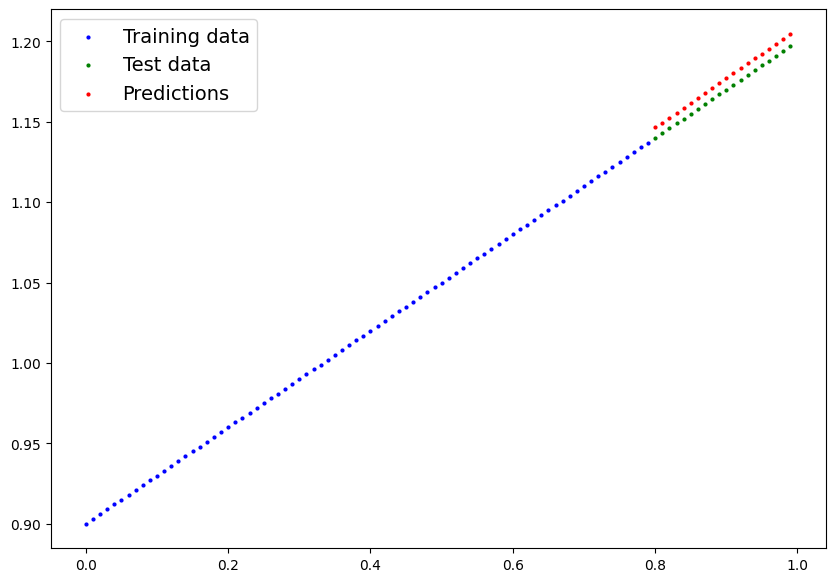

In [51]:
# Plot the predictions (these may need to be on a specific device)
plot_predictions(predictions = y_preds.cpu())


5. Save your trained model's `state_dict()` to file.

* Create a new instance of your model class you made in 2. and load in the `state_dict()` you just saved to it.
* Perform predictions on your test data with the loaded model and confirm they match the original model predictions from 4.


In [52]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True,exist_ok = True)
# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
# 3. Save the model state dict
print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj = model_1.state_dict(),f = MODEL_SAVE_PATH)

Saving model to models/01_pytorch_workflow_model_1.pth


In [53]:
# Create new instance of model and load saved state dict (make sure to put it on the target device)
loaded_model = LinearRegressionModel()
loaded_model.load_state_dict(torch.load(f = MODEL_SAVE_PATH))
loaded_model.to(device)

LinearRegressionModel()

In [54]:
# Make predictions with loaded model and compare them to the previous
y_preds_new = loaded_model(X_test)
y_preds == y_preds_new

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')

### Exercise (bis)

In [55]:
import torch
from torch import nn
import matplotlib.pyplot as plt

In [56]:
# Set up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [57]:
# Create data
weight = 0.3
bias = 0.9

X = torch.arange(start=0, end=1, step=0.01)
y = weight * X + bias

len(X), len(y)

(100, 100)

In [58]:
# Split data
train_split = int(0.8 * len(X))

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(80, 80, 20, 20)

In [59]:
# Create model
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.weight = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

    self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

  def forward(self, x):
    return self.weight * x + self.bias

In [60]:
torch.manual_seed(42)

# Instantiate
model_1 = LinearRegressionModel()

model_1.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [61]:
# Move model to device
model_1.to(device)

next(model_1.parameters()).device

device(type='cuda', index=0)

In [62]:
# Create loss function
loss_fn = nn.L1Loss()

# Create optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [63]:
# Training and testing loop
epochs = 300

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  # Set model to training mode
  model_1.train()

  # 1. Forward
  y_pred = model_1(X_train)

  # 2. Calculate loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Backpropagation
  loss.backward()

  # 5. Step optimizer
  optimizer.step()

  ### Testing
  model_1.eval()
  if epoch % 20 == 0:
    with torch.inference_mode():
      y_preds = model_1(X_test)
      test_loss = loss_fn(y_preds, y_test)

    # Printing
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}\nState: {model_1.state_dict()}")

Epoch: 0 | Loss: 0.7566978931427002 | Test loss: 0.7248174548149109
State: OrderedDict([('weight', tensor([0.3406], device='cuda:0')), ('bias', tensor([0.1388], device='cuda:0'))])
Epoch: 20 | Loss: 0.5254928469657898 | Test loss: 0.4541124403476715
State: OrderedDict([('weight', tensor([0.4196], device='cuda:0')), ('bias', tensor([0.3388], device='cuda:0'))])
Epoch: 40 | Loss: 0.2942880392074585 | Test loss: 0.18340764939785004
State: OrderedDict([('weight', tensor([0.4986], device='cuda:0')), ('bias', tensor([0.5388], device='cuda:0'))])
Epoch: 60 | Loss: 0.07658576965332031 | Test loss: 0.07274086028337479
State: OrderedDict([('weight', tensor([0.5712], device='cuda:0')), ('bias', tensor([0.7301], device='cuda:0'))])
Epoch: 80 | Loss: 0.05255373939871788 | Test loss: 0.11581540107727051
State: OrderedDict([('weight', tensor([0.5570], device='cuda:0')), ('bias', tensor([0.7858], device='cuda:0'))])
Epoch: 100 | Loss: 0.04554273188114166 | Test loss: 0.10467890650033951
State: Ordered

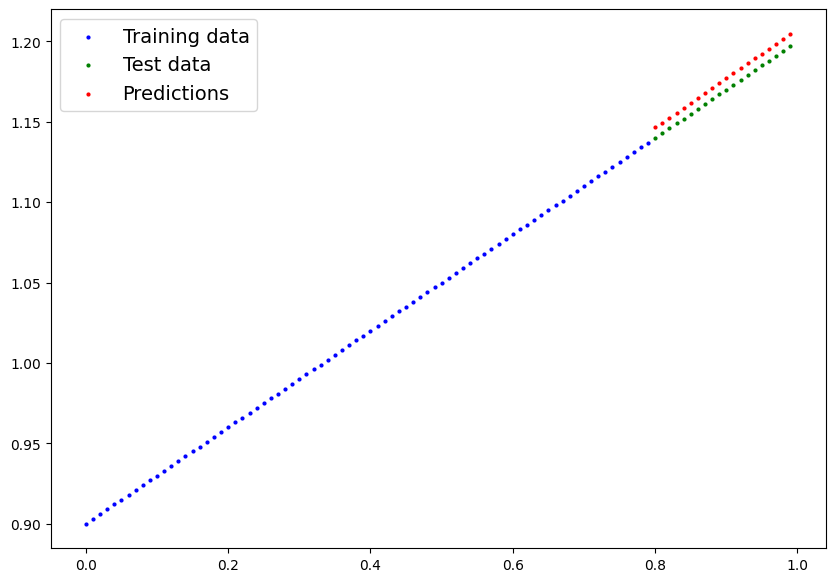

In [64]:
# Make predictions
model_1.eval()
with torch.inference_mode():
  y_preds = model_1(X_test)

plot_predictions(predictions = y_preds.cpu())